In [1]:

%matplotlib inline
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import FinanceDataReader as fdr

Using TensorFlow backend.


In [137]:
pandf = fdr.DataReader("KS11","2009.01.01","2019.01.01")
df=pandf


#특성 추가 ------------------------------------------
    #이동평균선
def get_MA(df):
    MA_26=df["Close"].rolling(26).mean()
    MA_52=df["Close"].rolling(52).mean()
    df=df.assign(MA_26=MA_26,MA_52=MA_52).dropna()
    
    return df

    
    #스토캐스틱
def get_stochastic(df, n=15, m=5, t=3):
    # n일중 최고가
    ndays_high = df.High.rolling(window=n, min_periods=1).max()
    # n일중 최저가
    ndays_low = df.Low.rolling(window=n, min_periods=1).min()
 
    # Fast%K 계산
    kdj_k = ((df.Close - ndays_low) / (ndays_high - ndays_low))*100
    # Fast%D (=Slow%K) 계산
    kdj_d = kdj_k.ewm(span=m).mean()
    # Slow%D 계산
    kdj_j = kdj_d.ewm(span=t).mean()
 
    # dataframe에 컬럼 추가
    df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
    
    return df
   
    #시간
def get_time(df):
    time=np.linspace(0,10,len(df),endpoint=False).reshape(-1,1)
    df=df.assign(time=time)
    
    return df




def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)
df=get_stochastic(df)
df=get_MA(df)
df['Momentum_1D'] = (df['Close']-df['Close'].shift(1))
df['RSI_14D'] = df['Momentum_1D'].rolling(center=False, window=14).apply(rsi)
df=df.dropna()

C:\Program Files\anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


In [138]:
for x in df:
    print(x)

Close
Open
High
Low
Volume
Change
kdj_k
kdj_d
kdj_j
MA_26
MA_52
Momentum_1D
RSI_14D


In [139]:
# convert nparray
nparr = df

# normalization
scaler = MinMaxScaler(feature_range=(0, 1))

y=np.where(df["Change"].shift(-1).dropna()>0,1,0)

In [140]:

df["Close"]=scaler.fit_transform(nparr["Close"].values.reshape(-1,1))
df["Open"]=scaler.fit_transform(nparr["Open"].values.reshape(-1,1))
df["High"]=scaler.fit_transform(nparr["High"].values.reshape(-1,1))
df["Low"]=scaler.fit_transform(nparr["Low"].values.reshape(-1,1))
df["Volume"]=scaler.fit_transform(nparr["Volume"].values.reshape(-1,1))
df["Change"]=scaler.fit_transform(nparr["Change"].values.reshape(-1,1))
df["kdj_k"]=scaler.fit_transform(nparr["kdj_k"].values.reshape(-1,1))
df["kdj_d"]=scaler.fit_transform(nparr["kdj_d"].values.reshape(-1,1))
df["kdj_j"]=scaler.fit_transform(nparr["kdj_j"].values.reshape(-1,1))
df["MA_26"]=scaler.fit_transform(nparr["MA_26"].values.reshape(-1,1))
df["MA_52"]=scaler.fit_transform(nparr["MA_52"].values.reshape(-1,1))
df["Momentum_1D"]=scaler.fit_transform(nparr["Momentum_1D"].values.reshape(-1,1))
df["RSI_14D"]=scaler.fit_transform(nparr["RSI_14D"].values.reshape(-1,1))

df=df[:-1]
X=df.values

In [74]:
# df = df[:-1].values # 1일차일시 [:-1] 20일차일시 [:-20]

# df.astype('float32')
# scaler = MinMaxScaler(feature_range=(0, 1))
# df = scaler.fit_transform(df)
# X=df
# df


array([[0.08774962, 0.08707471, 0.08125887, 0.07909785, 0.2815341 ,
        0.75432811],
       [0.09798782, 0.11720825, 0.09888968, 0.10908167, 0.3426833 ,
        0.62819456],
       [0.11110056, 0.11879917, 0.11053159, 0.11740842, 0.36701734,
        0.65787304],
       ...,
       [0.65608023, 0.66175402, 0.65323971, 0.66055328, 0.2356598 ,
        0.48722176],
       [0.63898492, 0.64824372, 0.63922759, 0.64055152, 0.26559795,
        0.40478153],
       [0.63925718, 0.65029814, 0.63779533, 0.64500959, 0.32884662,
        0.51442704]])

In [141]:
# split train, test

train_size = int(len(df) * 0.7)
y_train=y[:train_size]
y_test=y[train_size:]
X_train = X[:train_size]
X_test = X[train_size:]



In [142]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


X_train

array([[[0.02846301, 0.0169328 , 0.01264863, ..., 0.        ,
         0.58316029, 0.3843248 ]],

       [[0.        , 0.00831827, 0.        , ..., 0.00207824,
         0.38401068, 0.23500048]],

       [[0.04062509, 0.        , 0.02250836, ..., 0.0052553 ,
         0.84040344, 0.30848932]],

       ...,

       [[0.47060893, 0.48130479, 0.47214496, ..., 0.61360707,
         0.55235835, 0.18039752]],

       [[0.48963416, 0.47881311, 0.48003426, ..., 0.61180827,
         0.69771581, 0.28603172]],

       [[0.47745711, 0.47034291, 0.46448303, ..., 0.60989662,
         0.49159498, 0.2899942 ]]])

In [145]:
# simple lstm network learning
model = Sequential()
model.add(LSTM(36, input_shape=(1, 13)))
for i in range(2):
    model.add(Dense(36,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
result=model.fit(X_train, y_train, epochs=100, batch_size=16,validation_split=0.3)

Train on 1179 samples, validate on 506 samples
Epoch 1/100
1179/1179 [==============================] - 1s 989us/step - loss: 0.6938 - acc: 0.5165 - val_loss: 0.6936 - val_acc: 0.4980
Epoch 2/100
1179/1179 [==============================] - 0s 251us/step - loss: 0.6927 - acc: 0.5182 - val_loss: 0.6941 - val_acc: 0.4980
Epoch 3/100
1179/1179 [==============================] - 0s 210us/step - loss: 0.6921 - acc: 0.5182 - val_loss: 0.6931 - val_acc: 0.4862
Epoch 4/100
1179/1179 [==============================] - 0s 246us/step - loss: 0.6915 - acc: 0.5208 - val_loss: 0.6955 - val_acc: 0.4980
Epoch 5/100
1179/1179 [==============================] - 0s 274us/step - loss: 0.6908 - acc: 0.5335 - val_loss: 0.6931 - val_acc: 0.5020
Epoch 6/100
1179/1179 [==============================] - 0s 233us/step - loss: 0.6905 - acc: 0.5369 - val_loss: 0.6964 - val_acc: 0.4980
Epoch 7/100
1179/1179 [==============================] - 0s 251us/step - loss: 0.6922 - acc: 0.5216 - val_loss: 0.6935 - val_acc: 0

1179/1179 [==============================] - 0s 257us/step - loss: 0.6830 - acc: 0.5606 - val_loss: 0.7015 - val_acc: 0.4842
Epoch 61/100
1179/1179 [==============================] - 0s 244us/step - loss: 0.6829 - acc: 0.5556 - val_loss: 0.7032 - val_acc: 0.4822
Epoch 62/100
1179/1179 [==============================] - 0s 151us/step - loss: 0.6818 - acc: 0.5615 - val_loss: 0.6994 - val_acc: 0.4881
Epoch 63/100
1179/1179 [==============================] - 0s 188us/step - loss: 0.6811 - acc: 0.5649 - val_loss: 0.6991 - val_acc: 0.5178
Epoch 64/100
1179/1179 [==============================] - 0s 177us/step - loss: 0.6840 - acc: 0.5606 - val_loss: 0.7012 - val_acc: 0.4842
Epoch 65/100
1179/1179 [==============================] - 0s 302us/step - loss: 0.6829 - acc: 0.5505 - val_loss: 0.7014 - val_acc: 0.4783
Epoch 66/100
1179/1179 [==============================] - 0s 194us/step - loss: 0.6813 - acc: 0.5606 - val_loss: 0.7090 - val_acc: 0.4881
Epoch 67/100
1179/1179 [=======================

In [146]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,np.where(model.predict(X_test)>0.5,1,0))

0.4633471645919779

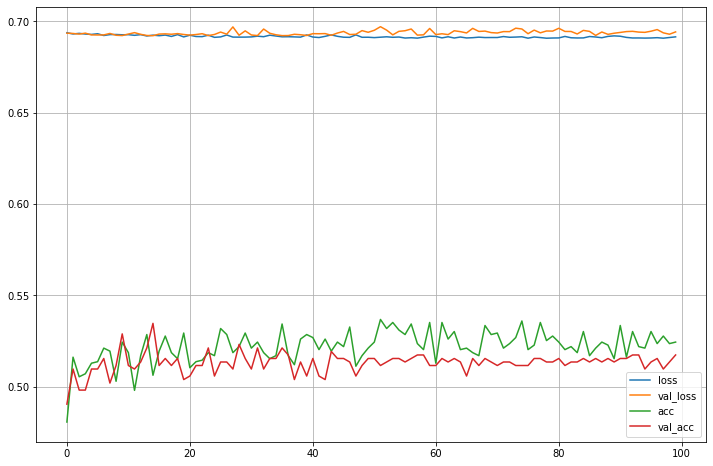

In [11]:
#-------------성과 측정 -------------
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.legend(['loss','val_loss', 'acc','val_acc'])
plt.grid()
plt.show()

In [12]:
y_pred.shape

NameError: name 'y_pred' is not defined

In [17]:
y_pred=model.predict(X_test)
y_test_class=np.argmax(y_test)

In [18]:
y_pred2=np.where(y_pred>0.5,1,0)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred2)

array([[285,  57],
       [338,  62]], dtype=int64)

In [20]:
y_test.shape

(742,)

In [23]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred2))

0.23892100192678226


In [ ]:
y_test.shape

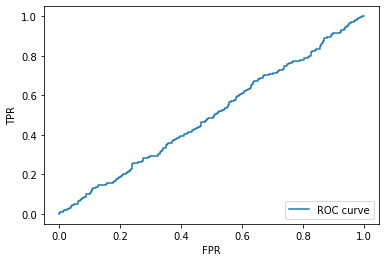

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred2)

from sklearn.metrics import roc_curve
y_prob=model.predict_proba(X_test)
fpr,tpr,thresholds=roc_curve(y_test,y_prob)
plt.plot(fpr,tpr,label="ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
close_zero=np.argmin(np.abs(thresholds))
plt.legend(loc=4)

In [36]:
y_prob=model.predict_proba(X_test)